# Define the system  

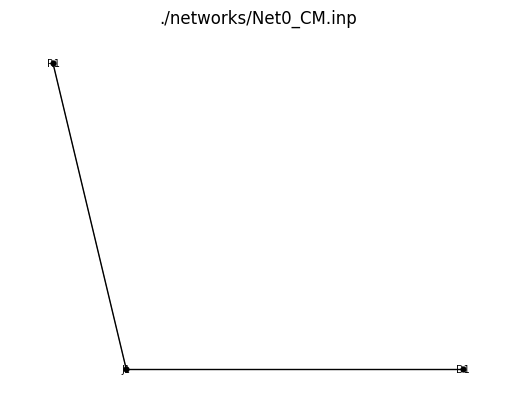

<Axes: title={'center': './networks/Net0_CM.inp'}>

In [1]:
import wntr
import wntr_quantum
import numpy as np

# Create a water network model
inp_file = './networks/Net0_CM.inp'
# inp_file = './networks/Net2LoopsDW.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)


## Run with the original Cholesky EPANET simulator

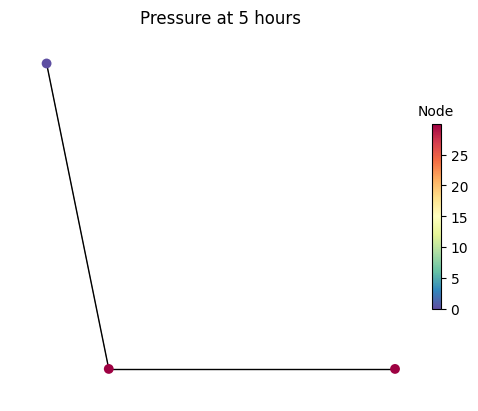

<Axes: title={'center': 'Pressure at 5 hours'}>

In [2]:
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()
# Plot results on the network
pressure_at_5hr = results.node['pressure'].loc[0, :]
wntr.graphics.plot_network(wn, node_attribute=pressure_at_5hr, node_size=50,
                        title='Pressure at 5 hours', node_labels=False)

In [3]:
ref_pressure = results.node['pressure'].values[0][:2]
ref_pressure

array([29.994, 29.988], dtype=float32)

In [4]:
ref_rate = results.link['flowrate'].values[0]
ref_rate

array([0.05, 0.05], dtype=float32)

In [5]:
ref_values = np.append(ref_rate, ref_pressure)
ref_values

array([ 0.05 ,  0.05 , 29.994, 29.988], dtype=float32)

## Run with the QUBO Polynomial Solver

In [6]:
wn = wntr.network.WaterNetworkModel(inp_file)

In [7]:
from wntr_quantum.sim.solvers.qubo_polynomial_solver import QuboPolynomialSolver
from qubops.solution_vector import SolutionVector_V2 as SolutionVector
from qubops.encodings import  RangedEfficientEncoding, PositiveQbitEncoding

nqbit = 9
step = (0.5/(2**nqbit-1))
flow_encoding = PositiveQbitEncoding(nqbit=nqbit, step=step, offset=+1.5, var_base_name="x")

nqbit = 9
step = (50/(2**nqbit-1))
head_encoding = PositiveQbitEncoding(nqbit=nqbit, step=step, offset=+50.0, var_base_name="x")

net = QuboPolynomialSolver(wn, flow_encoding=flow_encoding, 
              head_encoding=head_encoding)
net.verify_encoding()

Head Encoding : 50.000000 => 100.000000 (res: 0.097847)
Flow Encoding : 1.500000 => 2.000000 (res: 0.000978)


Solve the system classically

In [8]:
from wntr_quantum.sim.hydraulics import create_hydraulic_model
model, model_updater = create_hydraulic_model(wn)
net.matrices = net.initialize_matrices(model)

ref_sol = net.classical_solutions()
ref_sol / ref_values

/home/nico/QuantumApplicationLab/QuantumNewtonRaphson/quantum_newton_raphson/utils.py:74: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn("spsolve requires A be CSC or CSR matrix format", SparseEfficiencyWarning)


array([1., 1., 1., 1.])

In [9]:
from wntr_quantum.sim.hydraulics import create_hydraulic_model
from dwave.samplers import SteepestDescentSolver

sampler = SteepestDescentSolver()
model, model_updater = create_hydraulic_model(wn)
net.solve(model, options={"sampler" : sampler})
sol = net.extract_data_from_model(model)

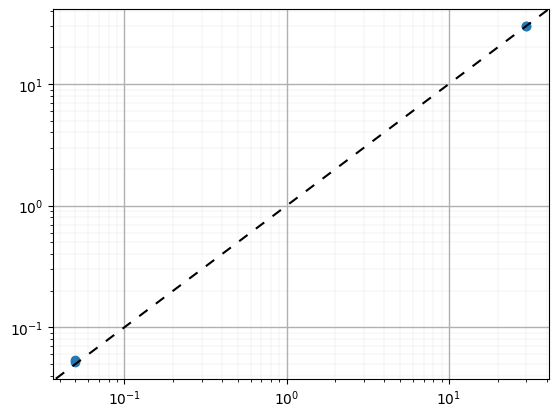

In [10]:
net.plot_solution_vs_reference(sol, ref_sol)

In [11]:
net.diagnostic_solution(sol, ref_sol)

Head Encoding : 50.000000 => 100.000000 (res: 0.097847)
Flow Encoding : 1.500000 => 2.000000 (res: 0.000978)


Error (%): [-7.892 -4.069 -0.029 -0.048]


sol :  [ 1.905  1.838 98.434 98.434]
ref :  [ 1.766  1.766 98.406 98.387]
diff:  [-0.139 -0.072 -0.028 -0.047]


encoded_sol:  [ 1.905  1.838 98.434 98.434]
encoded_ref:  [ 1.766  1.766 98.434 98.434]
diff       :  [-0.139 -0.071  0.     0.   ]


E sol   :  -2343.739974221478
R ref   :  -2343.749937932273
Delta E : 0.009963710795091174


Residue sol   :  0.10541453368914308
Residue ref   :  0.03388956865892264
Delta Residue : 0.07152496503022043


# Run with the intergrated WNTR Solver

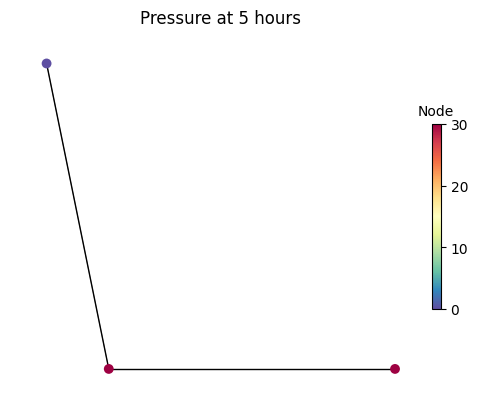

<Axes: title={'center': 'Pressure at 5 hours'}>

In [12]:
sim = wntr_quantum.sim.FullQuboPolynomialSimulator(wn, 
                                                   flow_encoding=flow_encoding, 
                                                   head_encoding=head_encoding)
results = sim.run_sim(solver_options={"sampler" : sampler})

# Plot results on the network
pressure_at_5hr = results.node['pressure'].loc[0, :]
wntr.graphics.plot_network(wn, node_attribute=pressure_at_5hr, node_size=50,
                        title='Pressure at 5 hours', node_labels=False)